In [3]:
import requests
import pandas as pd
import numpy as np
import io
from nba_api.stats.static import teams
from nba_api.stats.endpoints import leaguegamefinder
import matplotlib.pyplot as plt
from joypy import joyplot

In [9]:
play_by_play_url = "https://cdn.nba.com/static/json/liveData/playbyplay/playbyplay_0042000404.json"
response = requests.get(url=play_by_play_url).json()
play_by_play = response['game']['actions']
df = pd.DataFrame(play_by_play)
print(df.__dict__)
df[df['actionType'] == 'period'][['scoreHome', 'scoreAway']].head(5)


{'_is_copy': None, '_mgr': BlockManager
Items: Index(['actionNumber', 'clock', 'timeActual', 'period', 'periodType',
       'actionType', 'subType', 'qualifiers', 'personId', 'x', 'y',
       'possession', 'scoreHome', 'scoreAway', 'edited', 'orderNumber',
       'xLegacy', 'yLegacy', 'isFieldGoal', 'side', 'description',
       'personIdsFilter', 'teamId', 'teamTricode', 'descriptor',
       'jumpBallRecoveredName', 'jumpBallRecoverdPersonId', 'playerName',
       'playerNameI', 'jumpBallWonPlayerName', 'jumpBallWonPersonId',
       'jumpBallLostPlayerName', 'jumpBallLostPersonId', 'shotDistance',
       'shotResult', 'pointsTotal', 'assistPlayerNameInitial',
       'assistPersonId', 'assistTotal', 'shotActionNumber', 'reboundTotal',
       'reboundDefensiveTotal', 'reboundOffensiveTotal', 'turnoverTotal',
       'stealPlayerName', 'stealPersonId', 'officialId', 'foulPersonalTotal',
       'foulTechnicalTotal', 'foulDrawnPlayerName', 'foulDrawnPersonId',
       'blockPlayerName', 'blo

,scoreHome,scoreAway
0,0,0
125,20,23
130,20,23
264,52,52
273,52,52


In [6]:
gamefinder = leaguegamefinder.LeagueGameFinder(season_nullable='2021-22',
league_id_nullable='00',
season_type_nullable='Regular Season')
games = gamefinder.get_data_frames()[0]

game_ids = games['GAME_ID'].unique().tolist()

print(len(game_ids))

def get_data(game_id):
    play_by_play_url = "https://cdn.nba.com/static/json/liveData/playbyplay/playbyplay_"+game_id+".json"
    response = requests.get(url=play_by_play_url).json()
    play_by_play = response['game']['actions']
    df = pd.DataFrame(play_by_play)
    df['gameid'] = game_id
    return df

956


In [4]:
# get data from all ids (takes awhile)
pbpdata = []
for game_id in game_ids:
    game_data = get_data(game_id)
    pbpdata.append(game_data)
df = pd.concat(pbpdata, ignore_index=True)
# calculate time elapsed between a free throw and whatever action came before it
df = df.sort_values(by=['gameid', 'orderNumber'])
df['dtm'] = df['timeActual'].astype('datetime64[s]')
df['ptm'] = df['dtm'].shift(1)
df['elp'] = (df['dtm'] - df['ptm']).astype('timedelta64[s]')
df['pact'] = df['actionType'].shift(1)
df['psub'] = df['subType'].shift(1)
df['pmake'] = df['shotResult'].shift(1)
df[df['actionType'] == "freethrow"] 
df[df['elp'] > 0]
df = df[['gameid',
                     'clock',
                     'actionNumber',
                     'orderNumber',
                     'subType',
                     'pact',
                     'psub',
                     'dtm',
                     'ptm',
                     'pmake',
                     'elp',
                     'personId',
                     'playerNameI',
                     'shotResult',
                     'period']]


In [19]:

# read in cleaned data from GitHub, if you want
url = "https://raw.githubusercontent.com/Henryjean/data/main/cleanpbplogs2021.csv"
response = requests.get(url).content
df = pd.read_csv(io.StringIO(response.decode('utf-8')))

In [20]:
# filter df down to free throw attempts
df = df[(
    ((df.subType == '2 of 2') & ((df.psub == '1 of 2') | (df.psub == 'offensive'))) |
    ((df.subType == '2 of 3') & ((df.psub == '1 of 3') | (df.psub == 'offensive'))) |
    ((df.subType == '3 of 3') & ((df.psub == '2 of 3') | (df.psub == 'offensive')))
    )]

# find average time elapsed between 1st and 2nd (or 2nd and 3rd) FTs when previous action was a FT 
# get the count so we can filter for those with > 50
df['avgtime'] = df.groupby(['playerNameI', 'personId']).elp.transform('mean')
df['count'] = df.groupby(['playerNameI', 'personId']).elp.transform('count')
df = df[df['count'] > 50]
df = df.sort_values(['avgtime', 'playerNameI'], ascending=True)

<Figure size 432x288 with 0 Axes>

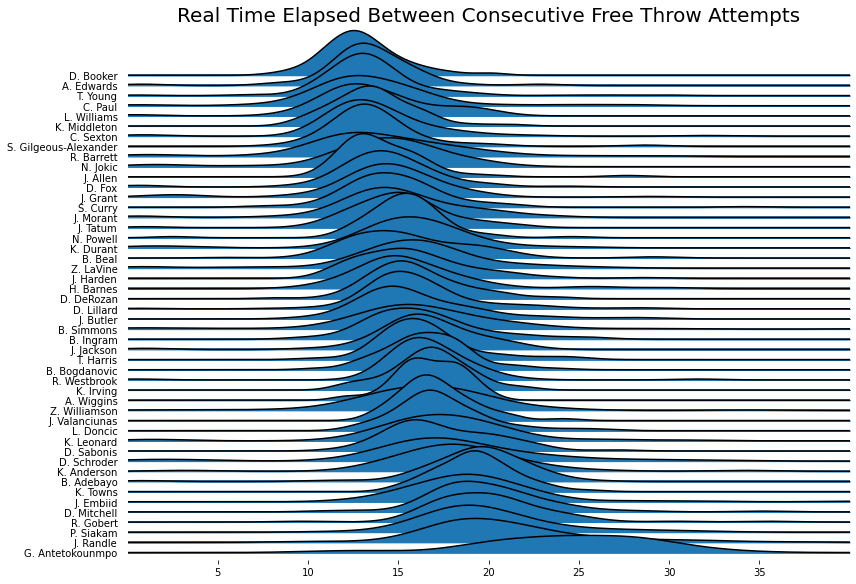

In [21]:
names = df['playerNameI'].unique().tolist()
plt.figure()

joyplot(
    data=df[['elp', 'avgtime', 'playerNameI']],
    by=('avgtime'),
    x_range=(0,40),
    labels=names,
    figsize=(12,8)
    )

plt.title('Real Time Elapsed Between Consecutive Free Throw Attempts', fontsize=20)
plt.show()